In [1]:
#@title Import Dependencies
import matplotlib
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-2 # size of step 

In [3]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [01:07<00:00, 147001.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 113945.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 653774.31it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 34387236.04it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [5]:
from torch.autograd import Function

class PhotonCountingP(nn.Module):
    """ The probability of 1 photon in photon counting 
        (also the expectation value) with mean flux x """
    def __init__(self):
        super(PhotonCountingP, self).__init__()

    def forward(self, x):
        return 1.-torch.exp(torch.abs(x)*-1.)
    
class BernoulliFunctionST(Function):
    """ The 'Straight Through' stochastic Bernoulli activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.bernoulli(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output

class PoissonFunctionST(Function):
    """ The 'Straight Through' stochastic Poisson activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.poisson(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output
    
PoissonST = PoissonFunctionST.apply    
BernoulliST = BernoulliFunctionST.apply 

In [6]:
#for photonActivation

# class Net(nn.Module):
#   def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
#     super(Net,self).__init__()
#     self.fc1 = nn.Linear(input_size, hidden_size)
#     self.relu = nn.ReLU()
#     self.fc2 = nn.Linear(hidden_size, num_classes)
#     self.act = PhotonCountingP()
#     self.sampler = BernoulliST
#     self.scale = scale
#     self.slope = slope
#     self.repeat = repeat
  
#   def forward(self,x):
#     out = self.fc1(x)
#     # out = self.relu(out)
#     probs = self.act(self.slope * out)
#     out = self.sampler(probs.unsqueeze(0).repeat((self.repeat,)+(1,)*len(probs.shape))).mean(axis=0)*torch.sign(out)
#     out = self.fc2(out)
#     return out

In [49]:

#for poisson
from torch.distributions import Exponential

def sample_poisson_relaxed(lmbd, num_samples=5, temperature = 0.01):
    sampler = torch.empty(num_samples)
    z = Exponential(torch.abs(lmbd)).rsample(sampler.size())
    t = torch.cumsum(z, 0)
    relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
    N = torch.cumsum(relaxed_indicator, 0)
    return N[-1]
    
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.repeat = repeat
  
  def forward(self,x):
    out = self.fc1(x)
    out = sample_poisson_relaxed(out, self.repeat)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [50]:
#@title Build the model

if torch.cuda.is_available():
  print(1)
else:
    print(0)

0


In [51]:
#@title Training the model


def runModel(count):
  accuracies = []
  # photonCounts = []
  hiddenLayer = []

  # finalaccuracies = []
  # finalCounts = []

  for j in [50,100,200,300,400]:
    hidden_size = j
    # count = j + 1
    net = Net(input_size, hidden_size, num_classes, repeat= count)
    if torch.cuda.is_available():
       net.cuda()
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam( net.parameters(), lr=lr)
    max = 0
    for epoch in range(num_epochs):
      for i ,(images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
          print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
        # if (i+1) % 100 == 0:
        #   print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.1f'
        #             %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item(), accuracy))
      correct = 0
      total = 0
      for images,labels in test_gen:
        images = Variable(images.view(-1,28*28))
        labels = labels
        
        output = net(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)

      accuracy = (100*correct)/(total+1)
      if max < accuracy.item():
        max = accuracy.item()

    accuracies.append(max)
    hiddenLayer.append(hidden_size)
        # photonCounts.append(count)
    # finalaccuracies.append(accuracy)
    # finalCounts.append(count)
  return accuracies, hiddenLayer
        

In [52]:

# for i in range(len(accuracies)):
#     accuracies[i] = accuracies[i].item()

# for i in range(len(finalaccuracies)):
#     finalaccuracies[i] = finalaccuracies[i].item()

In [53]:
#@title Evaluating the accuracy of the model

# correct = 0
# total = 0
# for images,labels in test_gen:
#   images = Variable(images.view(-1,28*28))
#   labels = labels
  
#   output = net(images)
#   _, predicted = torch.max(output,1)
#   correct += (predicted == labels).sum()
#   total += labels.size(0)

# print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

In [54]:
# import matplotlib.pyplot as plt
# print(photonCounts)
# print(accuracies)
# plt.plot(photonCounts, accuracies, 'o')
# plt.plot(finalCounts, finalaccuracies)
# plt.xlabel('Number of shots')
# plt.ylabel('accuracy')
# plt.title('Shot number vs. Accuracy after 10 epochs')
# plt.show()

Epoch [1/10], Step [100/600], Loss: 1.8859
Epoch [1/10], Step [200/600], Loss: 1.6995
Epoch [1/10], Step [300/600], Loss: 1.7083
Epoch [1/10], Step [400/600], Loss: 1.9315
Epoch [1/10], Step [500/600], Loss: 1.8837
Epoch [1/10], Step [600/600], Loss: 1.8107
Epoch [2/10], Step [100/600], Loss: 1.9307
Epoch [2/10], Step [200/600], Loss: 1.8870
Epoch [2/10], Step [300/600], Loss: 2.0143
Epoch [2/10], Step [400/600], Loss: 1.9673
Epoch [2/10], Step [500/600], Loss: 1.9666
Epoch [2/10], Step [600/600], Loss: 2.0691
Epoch [3/10], Step [100/600], Loss: 2.0477
Epoch [3/10], Step [200/600], Loss: 1.9288
Epoch [3/10], Step [300/600], Loss: 1.9113
Epoch [3/10], Step [400/600], Loss: 1.9727
Epoch [3/10], Step [500/600], Loss: 2.1289
Epoch [3/10], Step [600/600], Loss: 2.1720
Epoch [4/10], Step [100/600], Loss: 2.0712
Epoch [4/10], Step [200/600], Loss: 2.1193
Epoch [4/10], Step [300/600], Loss: 2.2210
Epoch [4/10], Step [400/600], Loss: 2.1137
Epoch [4/10], Step [500/600], Loss: 2.0226
Epoch [4/10

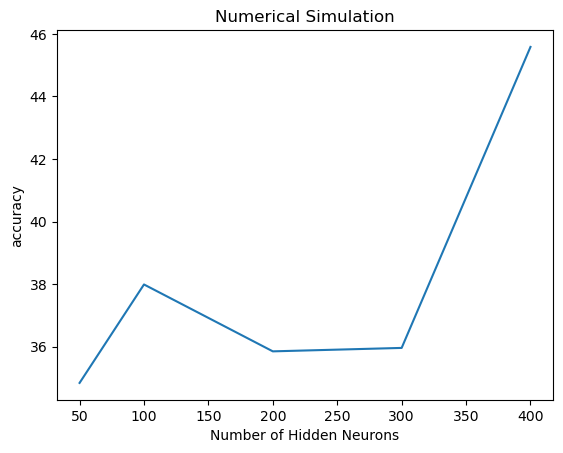

In [55]:
import matplotlib.pyplot as plt
accuracies1, size1 = runModel(1)
plt.plot(size1, accuracies1)
# accuracies2, size2 = runModel(2)
# plt.plot(size2, accuracies2)
# accuracies5, size5 = runModel(5)
# plt.plot(size5, accuracies5)
# accuracies100, size100 = runModel(100)
# plt.plot(size100, accuracies100)
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('accuracy')
plt.title('Numerical Simulation')
plt.show()

In [56]:
# print(accuracies1)
# size1 = []
# for i in range(10):
#     size1.append(50)
# for i in range(10):
#     size1.append(100)
# for i in range(10):
#     size1.append(150)
# for i in range(10):
#     size1.append(200)
# for i in range(10):
#     size1.append(250)
# for i in range(10):
#     size1.append(300)
# for i in range(10):
#     size1.append(350)
# for i in range(10):
#     size1.append(400)

# plt.plot(size1, accuracies1)
# plt.xlabel('Number of Hidden Neurons')
# plt.ylabel('accuracy')
# plt.title('Numerical Simulation')
# plt.show()
